# ROOT LOCUS DESIGN

This notebook introduces the root locus plot and its application to control design.
The focus is on p-control and closed loop dynamics such as stability, settling time, and oscillations.
The next lecture shows how to address closed loop DC gain.

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl
import numpy as np
try:
    import control
except:
    !pip install -q control
    import control
from typing import List, Tuple, Optional
from controlSBML.grid import Grid

In [2]:
TIMES = np.linspace(0, 10, 100)

# Helpers

## plotStep

In [3]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None,
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    #times, yv = control.step_response(tf, T=times)
    times, yv = control.step_response(tf)
    plt.plot(times, yv)
    if xlim is not None:
        plt.xlim(xlim)
    plt.title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [4]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [5]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [6]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# Theory

<img src="https://raw.githubusercontent.com/joseph-hellerstein/advanced-controls-lectures/main/short_class_lectures/images/simple_feedback.png"
         alt="Types of feature extractiom."
         width="600">

We want to find $H(s)$, the transfer function from the reference input $r(t)$ to the measured output $y(t)$.
Let $C(s)$ be the transfer function for the controller and $G(s)$ be the transfer function for the open loop system (OLS).
From the derivation in the last lecture, we know that
$${\Large H(s) = \frac{C(s) G(s)}{1 + C(s) G(s)}}$$
Note that $C(s) G(s)$ is the **forward** transfer function.


Root locus analysis focuses on proportional control (although we can adapt it to other controllers).
We assume that $G(s)$ is a rational polynomial; that is a ratio of two polynomials in $s$, 
$${\Large G(s) = \frac{N(s)}{D(s)}}$$.
So we have
$${\Large H(s) = \frac{k_P N(s)}{D(s) + k_P N(s)}}$$

The roots of $D(s)$ are the open loop poles.
The roots of $N(s)$ are the open loop zeros.

**Questions**
1. What are closed loop poles when $k_p \approx 0$?
2. What are the closed loop poles when $k_p \rightarrow \infty$?

# Root Locus Analysis

## Motivation

In [7]:
# An alternative way to construct a transfer function by specifying:
#    zeros, poles, multiplier times the transfer function
OL_TF = control.zpk([], [-2], [5])
OL_TF

TransferFunction(array([5.]), array([1., 2.]))

Let $G(s)$ be the open loop transfer function and $H(s)$ be the closed loop transfer function for p-control.
That is, $C(s) = k_P$. Consider the first order system $G(s) = \frac{k}{s - p}$.
\begin{eqnarray}
H(s) & = & \frac{C(s) G(s)}{1 + C(s) G(s)} \\
 & = & \frac{k_P k}{s - p + k_P k} \\
\end{eqnarray}

In [8]:
# Now create the closed loop transfer function for p-control with a gain of kP
kP = 2
cl_tf = control.feedback(kP*OL_TF) # Calculates H(s)
cl_tf

TransferFunction(array([10.]), array([ 1., 12.]))

We can compare choices for $k_P$ by calculating the transfer functions for different $k_P$.

In [9]:
kP = 3
cl1_tf = control.feedback(kP*OL_TF)
cl1_tf

TransferFunction(array([15.]), array([ 1., 17.]))

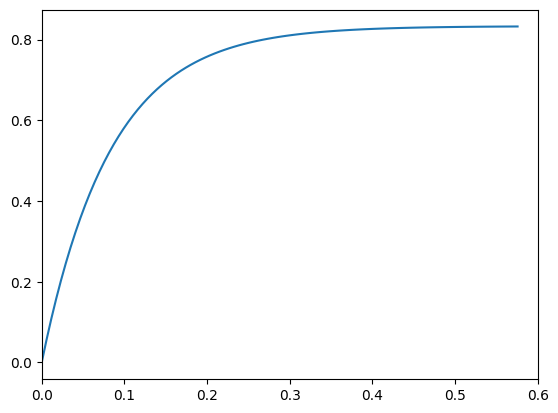

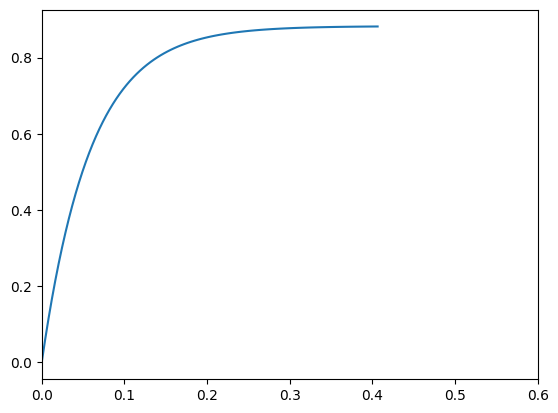

In [10]:
for kP in [2, 3]:
    cl_tf = control.feedback(kP*OL_TF) # closed loop transfer function
    tf = control.TransferFunction(cl_tf.num[0][0], cl_tf.den[0][0])
    plt.figure()
    plotStep(tf, xlim=[0, 0.6])

This is cumbersome and time consuming if we want to compare many designs. Also, it gives no insight into the effect of $k_P$.

**We want a more direct way to see the closed loop poles as $k_P$ is changed.**

## Root locus plots

The root locus plot displays the poles of the *closed loop* transfer function for the open loop under p-control.
* x-axis is the real part of the pole
* y-axis is the imaginary part of the pole
* Open loop poles are indicated by an "X"
* Open loop zeros are indicated by a red circle
* Blue lines are "branches" the path of closed loop poles as $k_P$ is changed

In [11]:
ol_tf = control.zpk([1], [-2], [5])
ol_tf

TransferFunction(array([ 5., -5.]), array([1., 2.]))

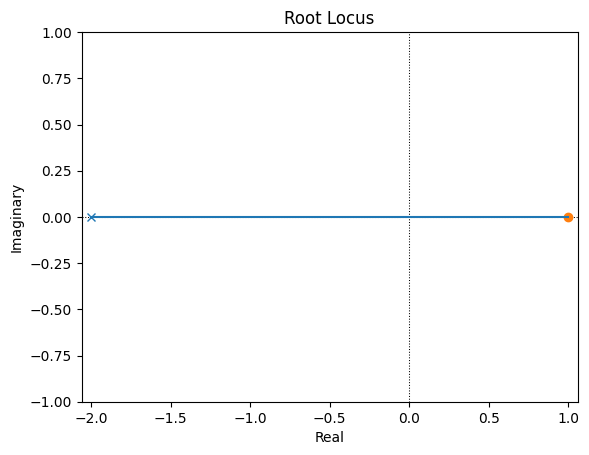

In [12]:
_ = control.root_locus(ol_tf, grid=False)

It's more insightful to annotate the plot with the poles as $k_P$ is varied.

Recall that the closed loop transfer function is
\begin{eqnarray}
H(s) & = & \frac{C(s) G(s)}{1 + C(s) G(s)} \\
& = & \frac{k_P \frac{5s - 5}{s + 2}}{1 + k_P \frac{5s - 5}{s + 2}} \\
& = & \frac{5 k_P (s - 1)}{s + 2 + 5 k_P (s - 1)} \\
\end{eqnarray}

We are going to focus on the **closed loop poles**. These are the roots of $s$ in the denominator. That is, the roots of 
$$s + 2 + 5 k_P (s - 1)$$

* What are the roots when $k_P = 0$? How does this relate to the open loop poles and zeros?
* What are the roots when $k_P = \infty$? How does this relate to the open loop poles and zeros?

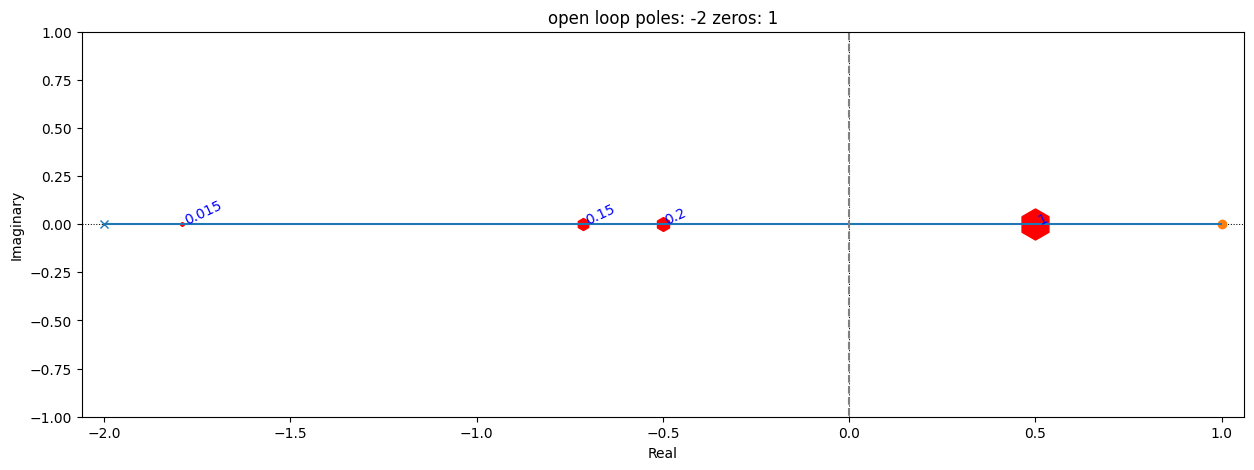

In [13]:
# Plot the open loop poles (hexagon) as kP increases
ol_tf = control.zpk([1], [-2], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1],
    markersize_multiplier=500, title="open loop poles: -2 zeros: 1",
    figsize=(15, 5), is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
2. Where does the branch start? Where does it end?
1. How do the poles "travel" as gain is increased?

There is one branch for each open loop pole. A single value of $k_P$ results in a new pole on each branch.

Now consider a different open loop system with two poles.

In [14]:
ol_tf = control.zpk([1], [-3, -4], [5])
ol_tf

TransferFunction(array([ 5., -5.]), array([ 1.,  7., 12.]))

<Axes: title={'center': 'poles: -4.0, -3.0  zeros: 1.0'}, xlabel='Real', ylabel='Imaginary'>

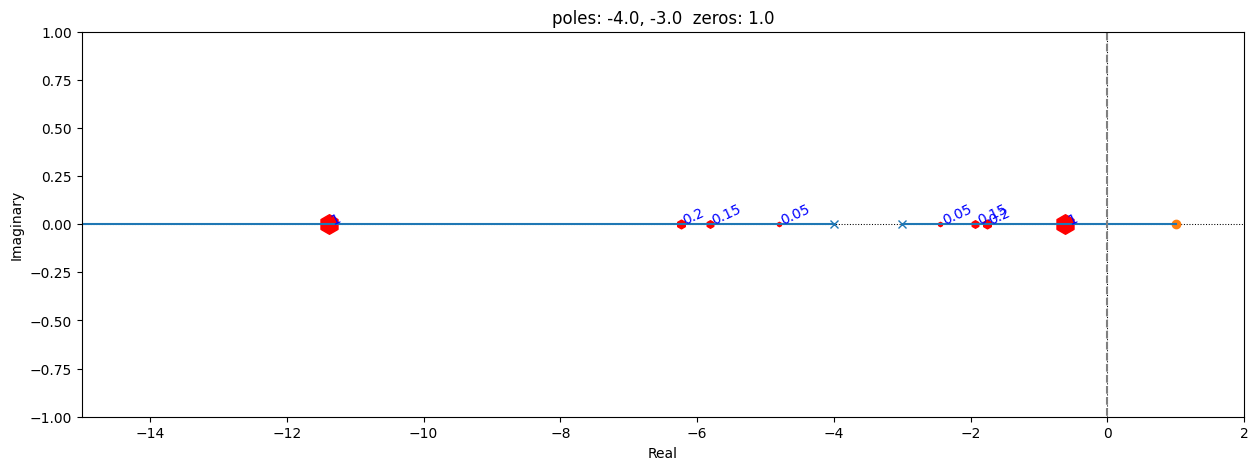

In [15]:
plotRootLocusWithGains(ol_tf, gains=[0.05, 0.15, 0.2, 1], markersize_multiplier=200,
    xlim=[-15, 2], is_annotate=True, figsize=(15, 5))

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
1. How do the closed loop poles move as $k_P$ is increased?
1. Are the closed loop poles bounded as we increase $k_P$?

<Axes: title={'center': 'poles: -4.0, -3.0  zeros: -3.5'}, xlabel='Real', ylabel='Imaginary'>

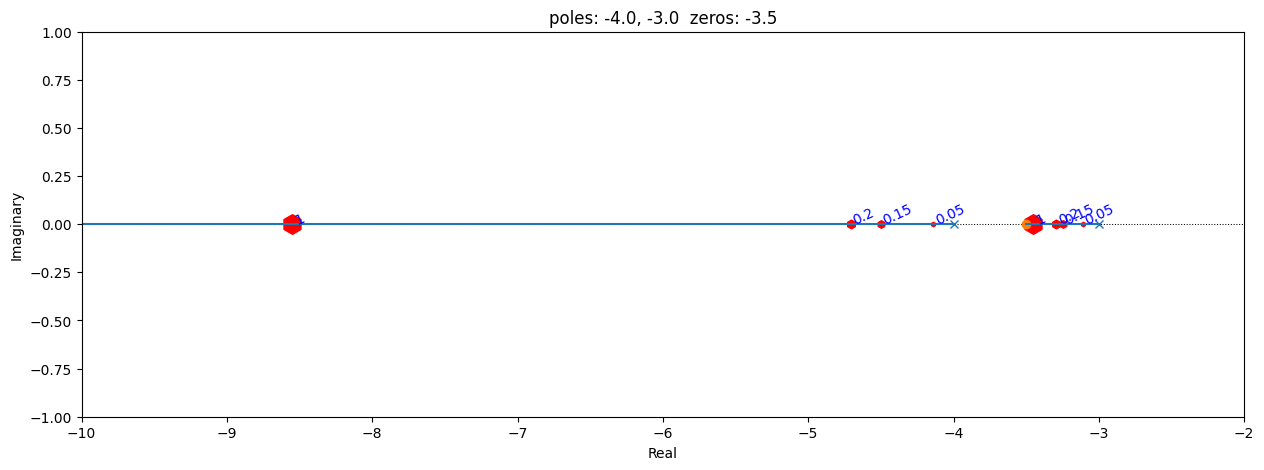

In [16]:
ol_tf = control.zpk([-3.5], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.05, 0.15, 0.2, 1], markersize_multiplier=200,
    xlim=[-10, -2], is_annotate=True, figsize=(15, 5))

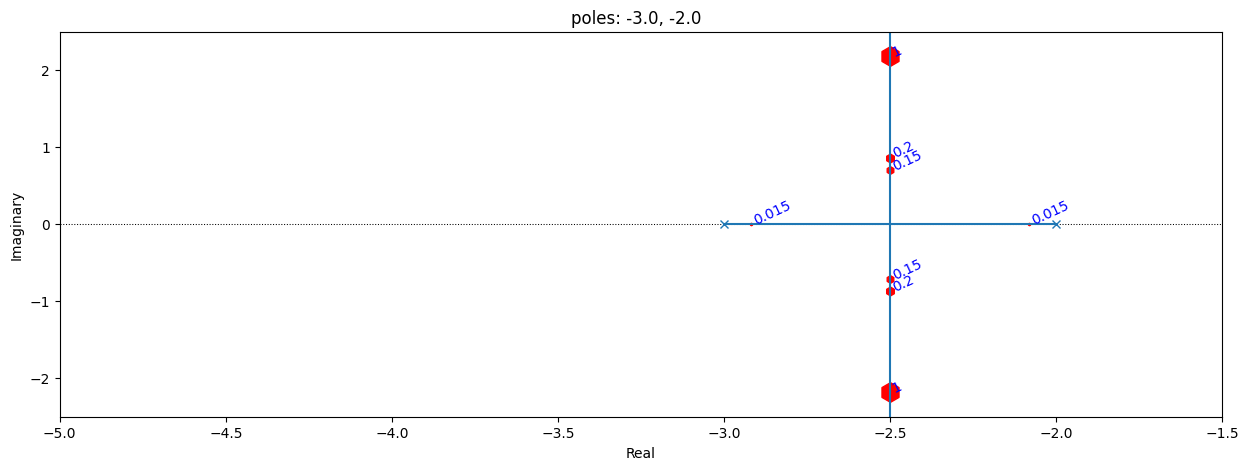

In [17]:
ol_tf = control.zpk([], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1], markersize_multiplier=200,
      xlim=[-5, -1.5], ylim=[-2.5, 2.5],
     figsize=(15, 5), is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
1. How do the closed loop poles move as $k_P$ is increased?
1. Are the closed loop poles bounded as we increase $k_P$?

A point at which a branch leaves the x-axis is a **breakaway point**.
A point at which a branch joins the x-axis is a **breakin point**.

<Axes: title={'center': 'poles: -4.0, -3.0  zeros: -10.0, -5.0'}, xlabel='Real', ylabel='Imaginary'>

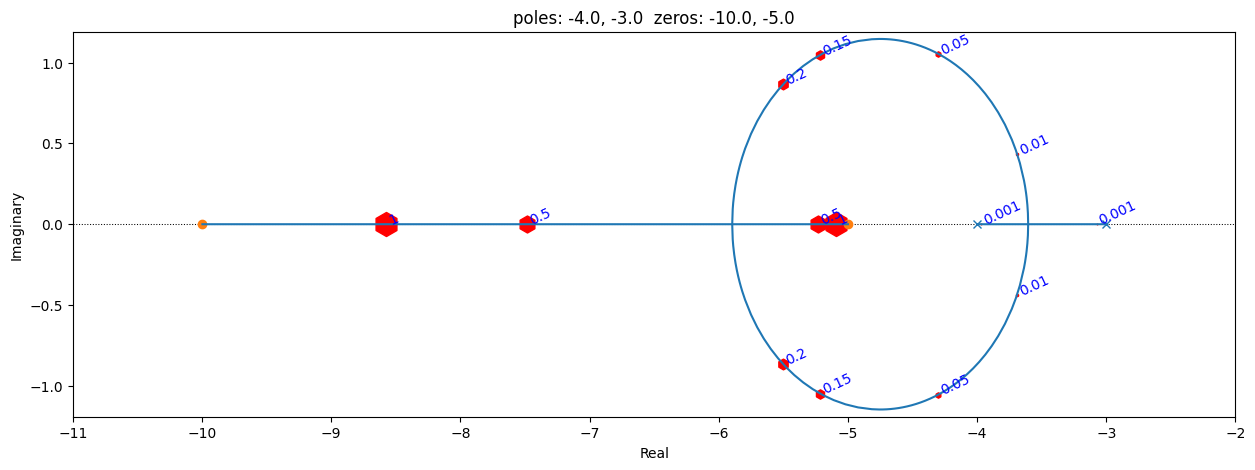

In [18]:
ol_tf = control.zpk([-5, -10], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[1e-3, 0.01, 0.05, 0.15, 0.2, 0.5, 1], markersize_multiplier=300,
    xlim=[-11, -2], figsize=[15, 5], is_annotate=True)

**Questions about this plot**
1. Where do the branches start?
2. Where do the branches end?
1. How many branches are there?
2. What is the breakaway point?
3. What is the breakin point?
4. How do the branches travel after the breakin point?

# Understanding Root Locus Plots

## 1. Branches begin at open loop poles and terminate at open loop zeros or infinity.

$$H(s) = \frac{k_P G(s)}{1 + k_P G(s)}$$

Let $G(s) = \frac{N(s)}{D(s)}$, where $D(s) = 0$ is the open loop characteristic equation.
Then
$$H(s) = \frac{k_P N(s)}{D(s) + k_P N(s)}$$

**Questions**
1. What are the poles of $H(s)$ when $k_P$ is very small?
1. What are the poles of $H(s)$ when $k_P$ is very large?

## 2. The root locus plot is symmetric about the x-axis.

This follows from the fact that since transfer functions have real valued coefficients, complex solutions for $s$ must include their complex conjugates. Complex conjugates are symmetric w.r.t. the x-axis.

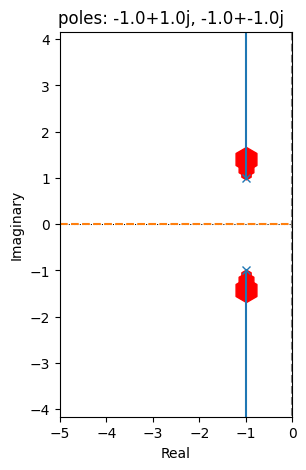

In [19]:
ol_tf = control.zpk([], [-1+1j, -1-1j], [1])
ax = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 5),
    xlim=[-5, 0], is_annotate=False)
ax.plot([-5, 0], [0, 0], linestyle="--")

## 3. Location of branches

Let $s$ be a point on the real axis. $s$ is a closed pole for some $k_P$ if there are an odd number of poles
and zeros to its right on the real axis

<Axes: title={'center': 'poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

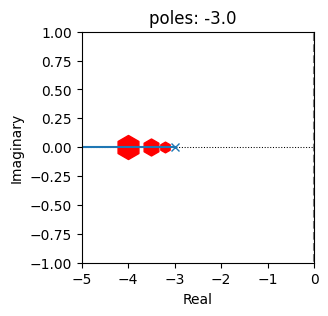

In [20]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3),
    xlim=[-5, 0], is_annotate=False)

<Axes: title={'center': 'poles: -4.0, -1.0  '}, xlabel='Real', ylabel='Imaginary'>

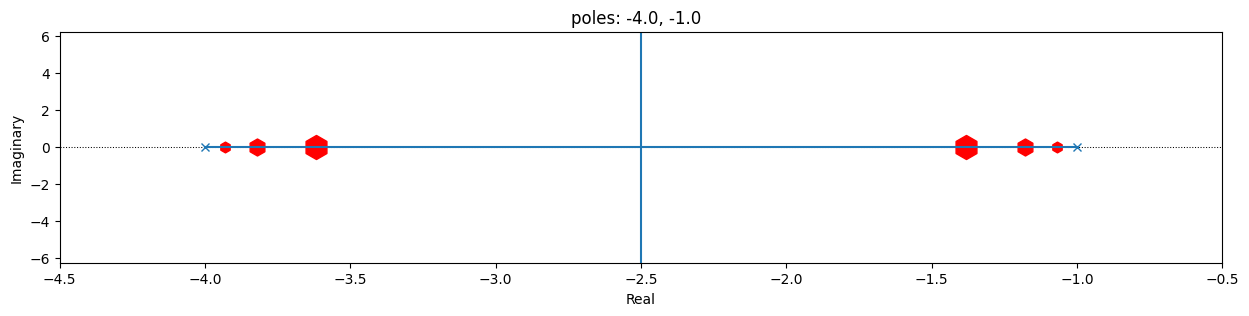

In [21]:
ol_tf = control.zpk([], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 3),
    xlim=[-4.5, -0.5], is_annotate=False)

<Axes: title={'center': 'poles: -4.0, -1.0  zeros: -2.0'}, xlabel='Real', ylabel='Imaginary'>

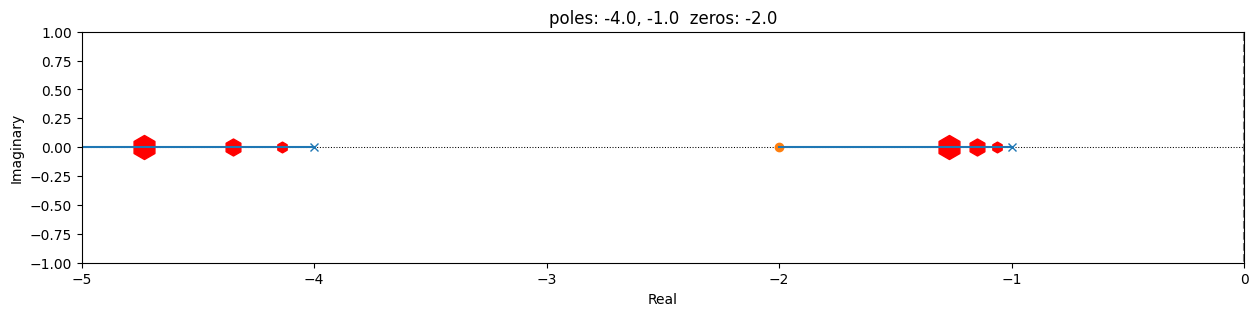

In [22]:
ol_tf = control.zpk([-2], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1],
    markersize_multiplier=300, figsize=(15, 3),
    xlim=[-5, 0], is_annotate=False)

**Proof**:
We know that for $s$ to be a pole, it must satisfy $1 + k_P G(s) = 0$ or $k_PG(s) = -1$.
$G(s) = \frac{\prod_m (s - z_m)}{\prod_n (s - p_n)}$.

For $G(s)$ to be negative, an odd number $z_m, p_n$ must be negtive.
That is an odd number of open loop poles and zeros must be to the right $s$.

## 4. Angle of asymptotes is $\alpha$ s.t. $(N_P - N_Z) \alpha = \pm 180 + k*360$

$N_P$ is the number of open loop poles; $N_Z$ is the number of open loop zeros.
$k \in \{0, \pm1, \pm2, \cdots \}$.


**Example 1**: $G(s) = \frac{1}{s + 3}$
* $N_P =1$, $N_Z = 0$.
* One asymptote. On x-axis to $-\infty$

<Axes: title={'center': 'poles: -3.0  '}, xlabel='Real', ylabel='Imaginary'>

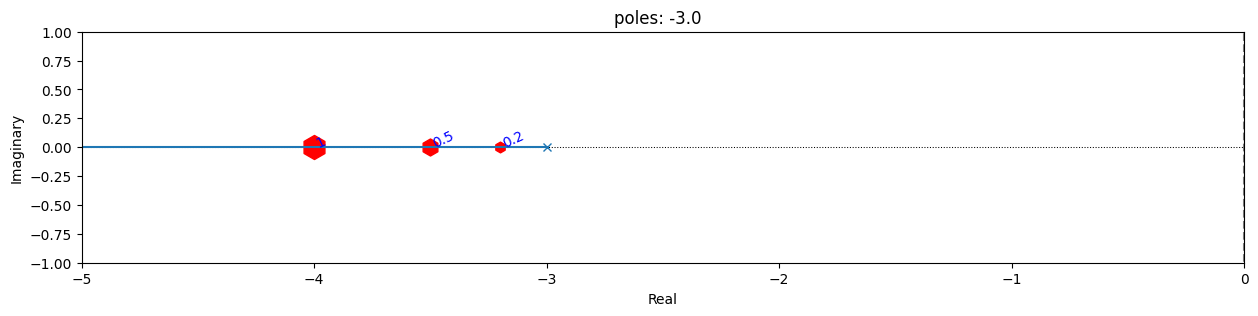

In [23]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 3),
    xlim=[-5, 0], is_annotate=True)

**Example 2**: $G(s) = \frac{s + 1}{s + 3}$
* $N_P =1$, $N_Z = 1$.
* No asymptote.

<Axes: title={'center': 'poles: -3.0  zeros: -1.0'}, xlabel='Real', ylabel='Imaginary'>

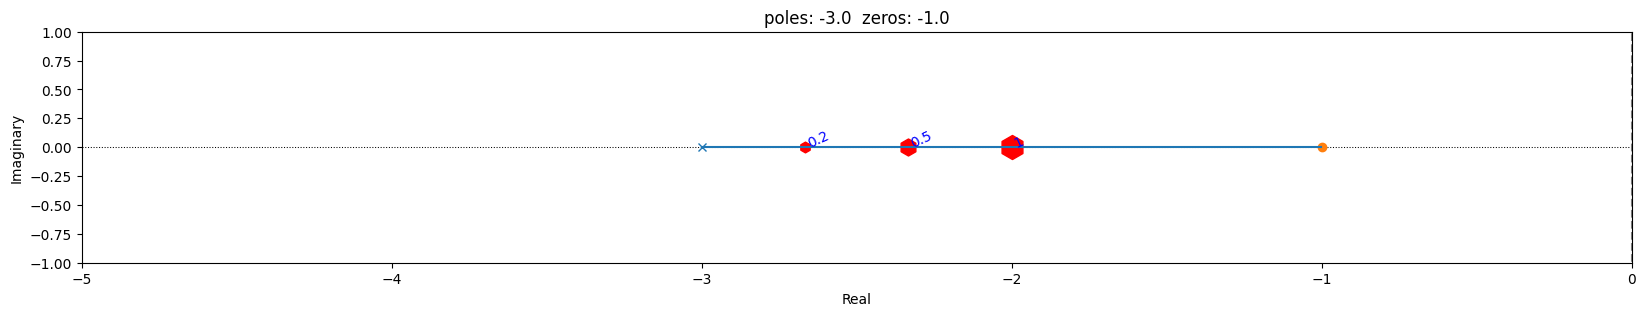

In [24]:
ol_tf = control.zpk([-1], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(20, 3),
    xlim=[-5, 0], is_annotate=True)

**Example 3**: $G(s) = \frac{1}{(s + 1)(s + 3)(s + 4)}$
* $N_P =3$, $N_Z = 0$.
* Asymptotes
  * 180
  * 60
  * -60

<Axes: title={'center': 'poles: -4.0, -3.0, -1.0  '}, xlabel='Real', ylabel='Imaginary'>

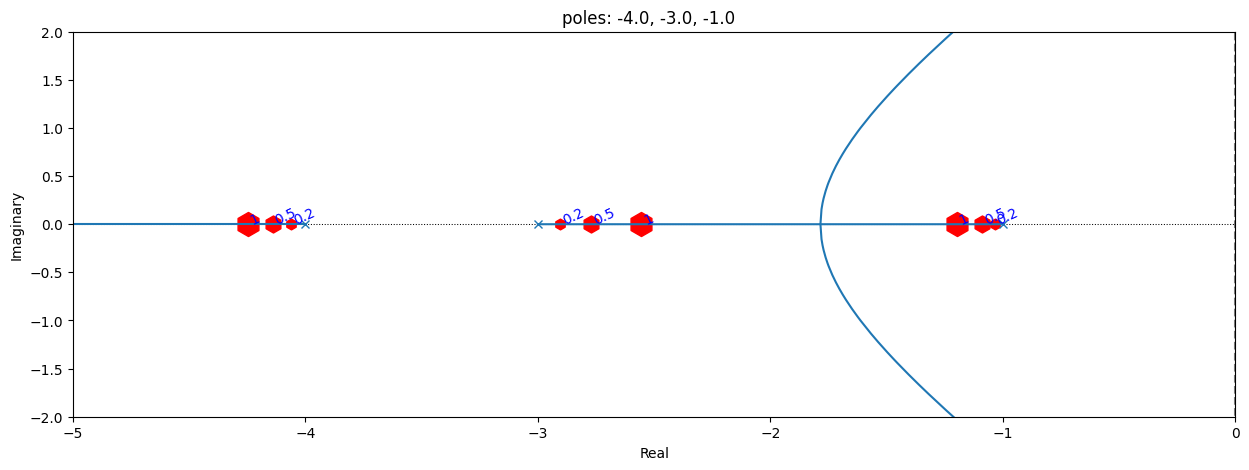

In [25]:
ol_tf = control.zpk([], [-1, -3, -4], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300,
    figsize=(15, 5),
    ylim=[-2, 2], xlim=[-5, 0], is_annotate=True)

**Proof**:
For large $s$, its angle with all poles and zeros is the same. We denote this angle by $\alpha$.
That is,
\begin{eqnarray}
\angle \left( \frac{N(s)}{D(s)} \right) & = & 180  \\
\alpha N_Z  - \alpha N_P  & = & 180\\
\alpha & = & -\frac{180}{N_P - N_Z}
\end{eqnarray}
Note that $\alpha + k 360 = \alpha$, for $k = 0, \pm1, \pm2, \cdots$.

Note: There is no asymptote if $N_P = N_Z$.

# Designing P Control With Root Locus

**Design objective: Minimize the dominant.**

Using root locus for designing p-control.
1. Draw the (annotated) root locus plot.
2. Find the value of $k_P$ that minimizes the dominant pole.

## Case 1: 1 pole; no zeros.



**Approach**: Maximize $k_P$ since the asymptote for closed loop poles goes to $-\infty$

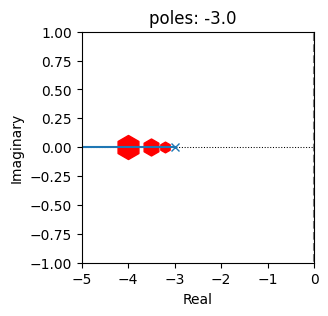

In [26]:
ol_tf = control.zpk([], [-3], [1])
_ = plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3),
    xlim=[-5, 0], is_annotate=False)



```
# This is formatted as code
```

## Case 2: 2 poles; no zeros

**Approach**: Find $k_P$ at the breakaway point.

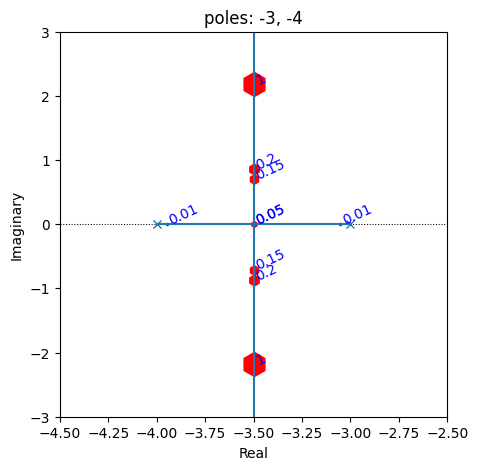

In [27]:
ol_tf = control.zpk([], [-3, -4], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300, title="poles: -3, -4",
    xlim=[-4.5, -2.5], ylim=[-3, 3], is_annotate=True)

## Case 3: 2 poles; 1 zero.

**Approach**:
1. If $z > max(p_1, p_2)$, minimize $k_P$.
2. If $p_1 < z < p_2$, choose $k_P$ so that dominant closed loop pole is close to $z$.
3. If $z < p_1 < p_2$, choose $k_P$ at the breakin point.

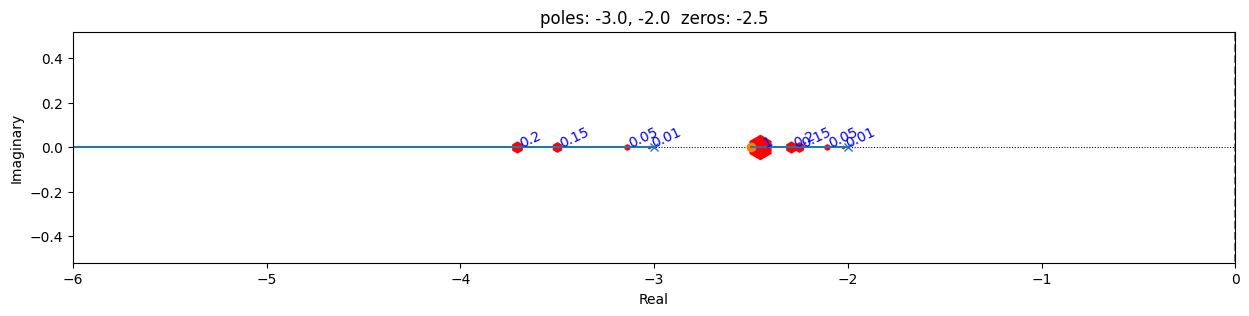

In [28]:
# Case 1: p1, p2 < z
ol_tf = control.zpk([-2.5], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-6, 0], figsize=(15, 3), is_annotate=True)

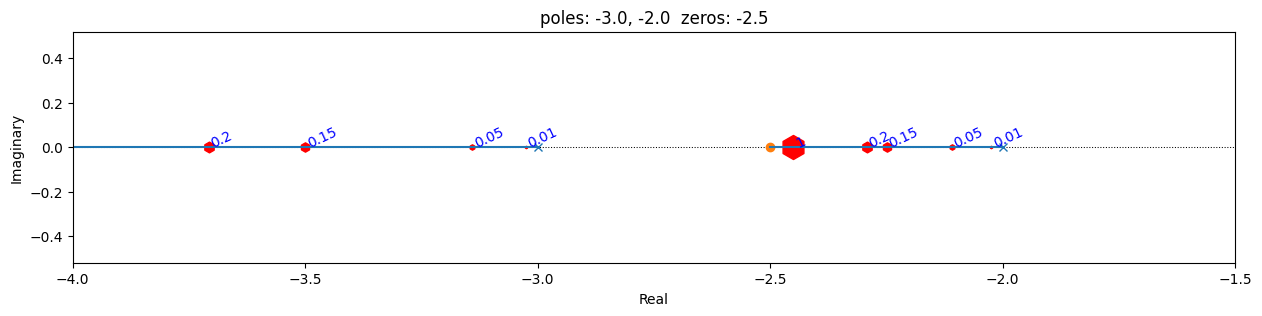

In [29]:
# Case 2: p1 < z < p2
ol_tf = control.zpk([-2.5], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-4, -1.5], figsize=(15, 3), is_annotate=True)

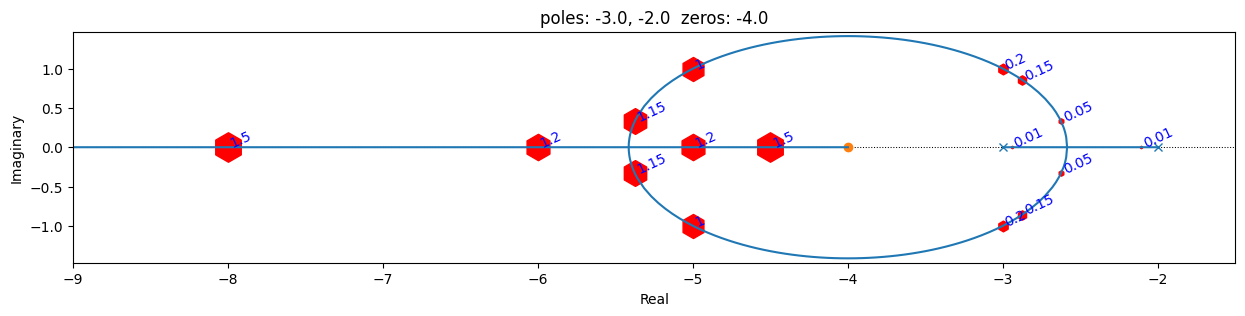

In [30]:
# Case 3: z < p1, p2
ol_tf = control.zpk([-4], [-2, -3], [5])
_ = plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1, 1.15, 1.2, 1.5], markersize_multiplier=300,
    xlim=[-9, -1.5], figsize=(15, 3), is_annotate=True)

# Designing PI control Using Root Locus Analysis

Root locus is about designing for a single design parameter.
PI control has two design parameters. 
Consider making RL plots with conbinations of parameters.

$C_{PI} (s) = k_P + \frac{k_I}{s}$

So, $H_F(s)$, the forward transfer function, is
\begin{eqnarray}
H_F(s) & = & C(s) G(s) \\
 & = & k_P + \frac{k_I}{s} G(s) \\
 & = & \frac{s k_P + k_I}{s} G(s) \\
 & = & k_P \frac{s + k_I/k_P}{s} G(s) \\
H_F(s; k_P, r_{IP}) & = & k_P \frac{s + r_{IP}}{s} G(s)
\end{eqnarray}

We use $r_{IP} = \frac{k_I}{k_P}$ to be the ratio between $k_I$ to $k_P$. 

So we can use $H_F(s; 1, r_{IP})$ as the *adjusted* open loop system.

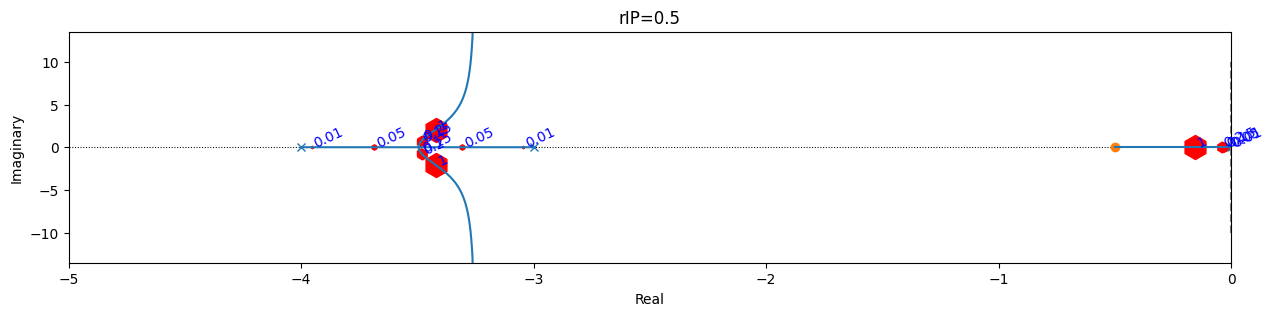

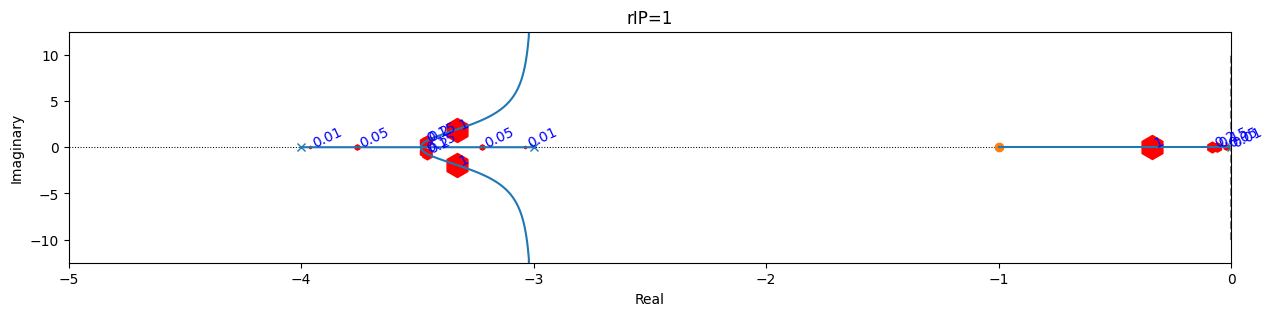

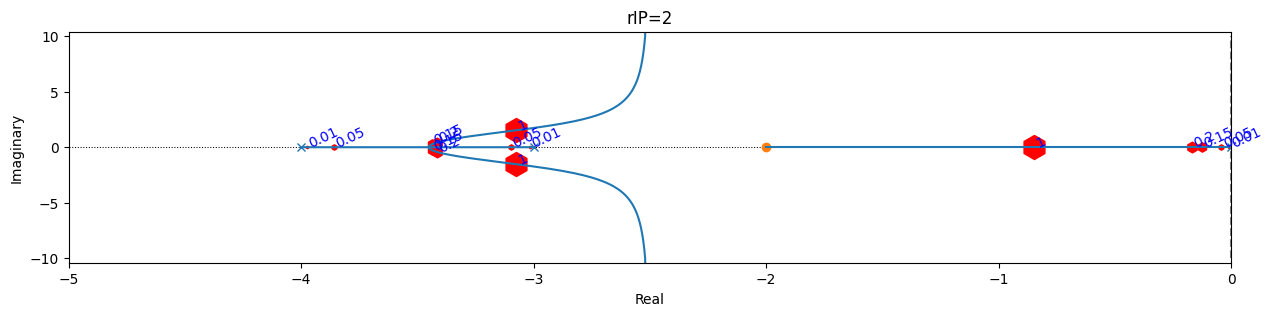

In [31]:
# Iteratively consider multiple values of rIP
ol_tf = control.zpk([], [-3, -4], [5])
s = control.TransferFunction.s
for rIP in [0.5, 1, 2]:
    adj_ol_tf = (s + rIP)/s * ol_tf  # Adjusted open loop system
    _ = plotRootLocusWithGains(adj_ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
        xlim=[-5, 0], figsize=(15, 3), is_annotate=True, title=f"rIP={rIP}")

We get $k_I$ by multiplying $r_{IP}$ times chosen in the $k_P$ in plot.

# Design Workflow

## Model

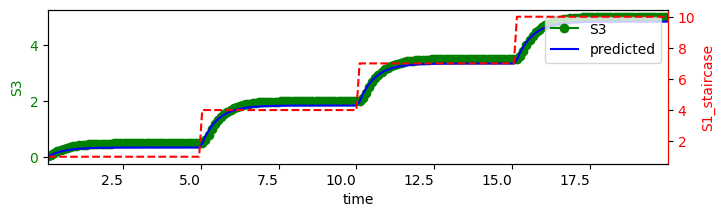


     0.498
----------------
0.4955 s + 1.001

[-2.01973723+0.j]


In [32]:
SEQUENTIAL_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 10
k3 = 2
end
"""
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, times=TIMES,
        input_name="S1", output_name="S3")
_ = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=1,
            initial_value=1, final_value=10, num_step=3,
            times=np.linspace(0, 20, 200), figsize=(8, 2))
SEQUENTIAL_TF = SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()
print(SEQUENTIAL_TF)
print(SEQUENTIAL_TF.poles())

## Theory based design

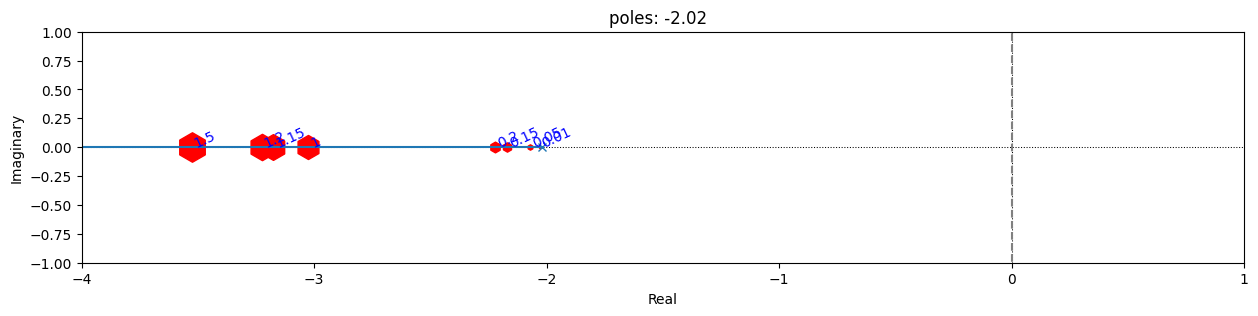

In [33]:
_ = plotRootLocusWithGains(SEQUENTIAL_TF, gains=[0.01, 0.05, 0.15, 0.2, 1, 1.15, 1.2, 1.5], markersize_multiplier=300,
    xlim=[-4, 1], figsize=(15, 3), is_annotate=True)

## Grid search using theory

In [34]:
?SEQUENTIAL_CTLSB.plotGridDesign

Signature:
SEQUENTIAL_CTLSB.plotGridDesign(
    grid: controlSBML.grid.Grid,
    setpoint: Optional[float] = 1,
    sign: Optional[float] = -1,
    times: Optional[numpy.ndarray] = None,
    num_process: Optional[int] = -1,
    num_restart: Optional[int] = 1,
    selections: Optional[List[str]] = None,
    **kwargs,
) -> controlSBML.control_sbml.DesignResult
Docstring:
Plots the results of a closed loop design based a grid of values for the control parameters.
Persists the closed loop design (kP, kI, kD, kF) if a design is found.

Args:
    grid: Grid (grid of values for the control parameters)
    setpoint: float (regulation point)
    sign: float (direction of feedback: -1 or 1)
    times: numpy array (times of simulation)
    num_process: int (number of processes to use; -1 means use all available)
    selections: list-str (selections for the simulation)
    kwargs: dict (plot options)
Returns:
    DesignResult
        timeseries: Timeseries
        antimony_builder: AntimonyBuilder

100%|██████████| 100/100 [00:00<00:00, 156.43it/s]


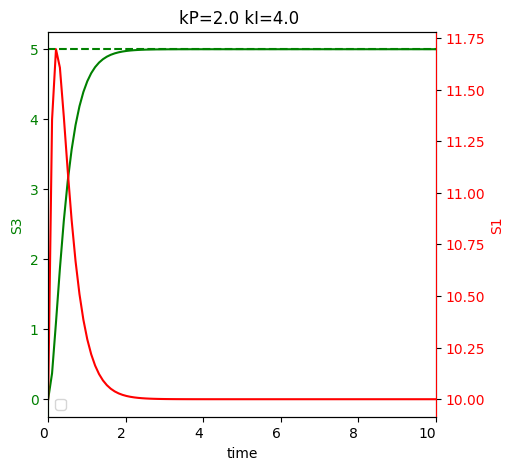

In [35]:
grid = Grid()
grid.addAxis("kP", min_value=0, max_value=2, num_coordinate=10)
grid.addAxis("kI", min_value=0.000, max_value=4, num_coordinate=10)
_ = SEQUENTIAL_CTLSB.plotGridDesign(grid, setpoint=5, times=np.linspace(0, 10, 100), xlim=[0, 10], is_plot=True)

## Fine tuning

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.96it/s]


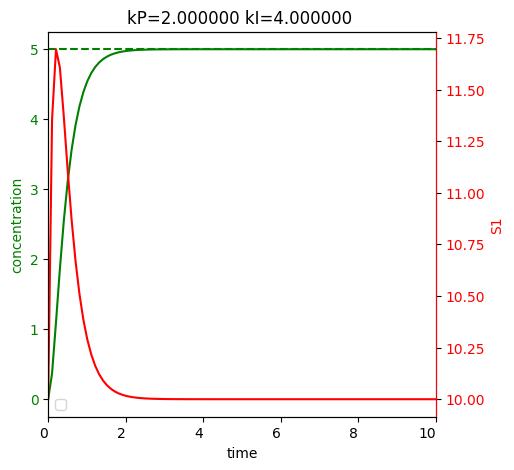

In [36]:
_ = SEQUENTIAL_CTLSB.plotDesign(kP_spec=2.0, kI_spec=4, setpoint=5, times=np.linspace(0, 10, 100), xlim=[0, 10])